In [443]:
with open("./datos_filtrados.txt", 'r') as archivo:
    lineas = archivo.readlines()

t_values = []
a_values = []
v_values = []
d_values = []
for linea in lineas:
    data_values = linea.strip().split(';')
    if len(data_values) == 4:
        t_values.append(int(data_values[0][1:]))
        
        a_value = int(data_values[1][1:]) if data_values[1][0] == 'A' else int(data_values[1][1:])
        a_values.append(a_value)

        v_value = int(data_values[2][1:].split(' ')[0]) if data_values[2][0].isdigit() else int(data_values[2][1:])
        v_values.append(v_value)

        d_values.append(int(data_values[3][1:]))

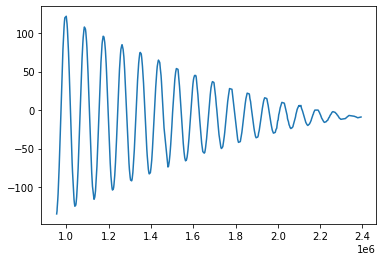

In [444]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(t_values[117:],a_values[117:])

-135


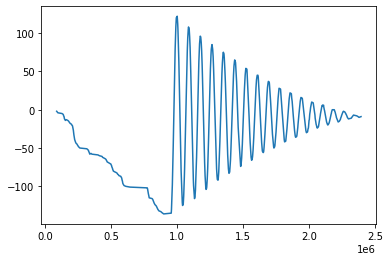

In [445]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(t_values,a_values)
print(a_values[115])

In [515]:
from scipy.optimize import curve_fit
from math import tau
import numpy as np

guess1 = [1,.1,5]

guess2 = [1,5]

guess3 = [1,5]

guess4 = [1,1,5,1,1]

guess5 = [0.001,0,7.18302943,-5.8e-5]

y = np.array(a_values[117:])
y = y*tau/730
y0 = y[0]
t = np.array(t_values[117:])
t = (t-t[0])/100000


def model1(t,*params):
    a,b,w = params
    return np.exp(-b*t)*(y0 + a*t)*np.cos(w*t)

def model2(t,*params):
    a,w = params
    return (y0 + a*t)*np.cos(w*t)

def model3(t,*params):
    b,w = params
    return (y0)*np.exp(-b*t)*np.cos(w*t)

def model4(t,*params):
    a,b,w,c,d = params
    return np.exp(-b*t)*(y0 + a*t)*np.cos((w+d*t)*t) + c*t

params1,covariance1,*info = curve_fit(model1,t,y,guess1,xtol = 0.00000001,full_output = True)
params2,covariance2,*info = curve_fit(model2,t,y,guess2,xtol = 0.0001,full_output = True)
params3,covariance3,*info = curve_fit(model3,t,y,guess3,xtol = 0.0001,full_output = True)
params4,covariance4,*info = curve_fit(model4,t,y,guess4,xtol = 0.0001,full_output = True)

formulas = [r'$e^{-bt} \cdot (y0 + at) \cdot \cos(wt)$',
            r'$(y0 + at) \cdot \cos(wt)$',
            r'$e^{-bt} \cdot (y0) \cdot \cos(wt)$',
            r'$e^{-bt} \cdot (y0 + at) \cdot \cos((w + dt) \cdot t) + ct$']

param_names = [('a','b','w'),('a','w'),('b','w'),('a','b','w','c','d')]

models = [model1,model2,model3,model4]
params = [params1,params2,params3,params4]

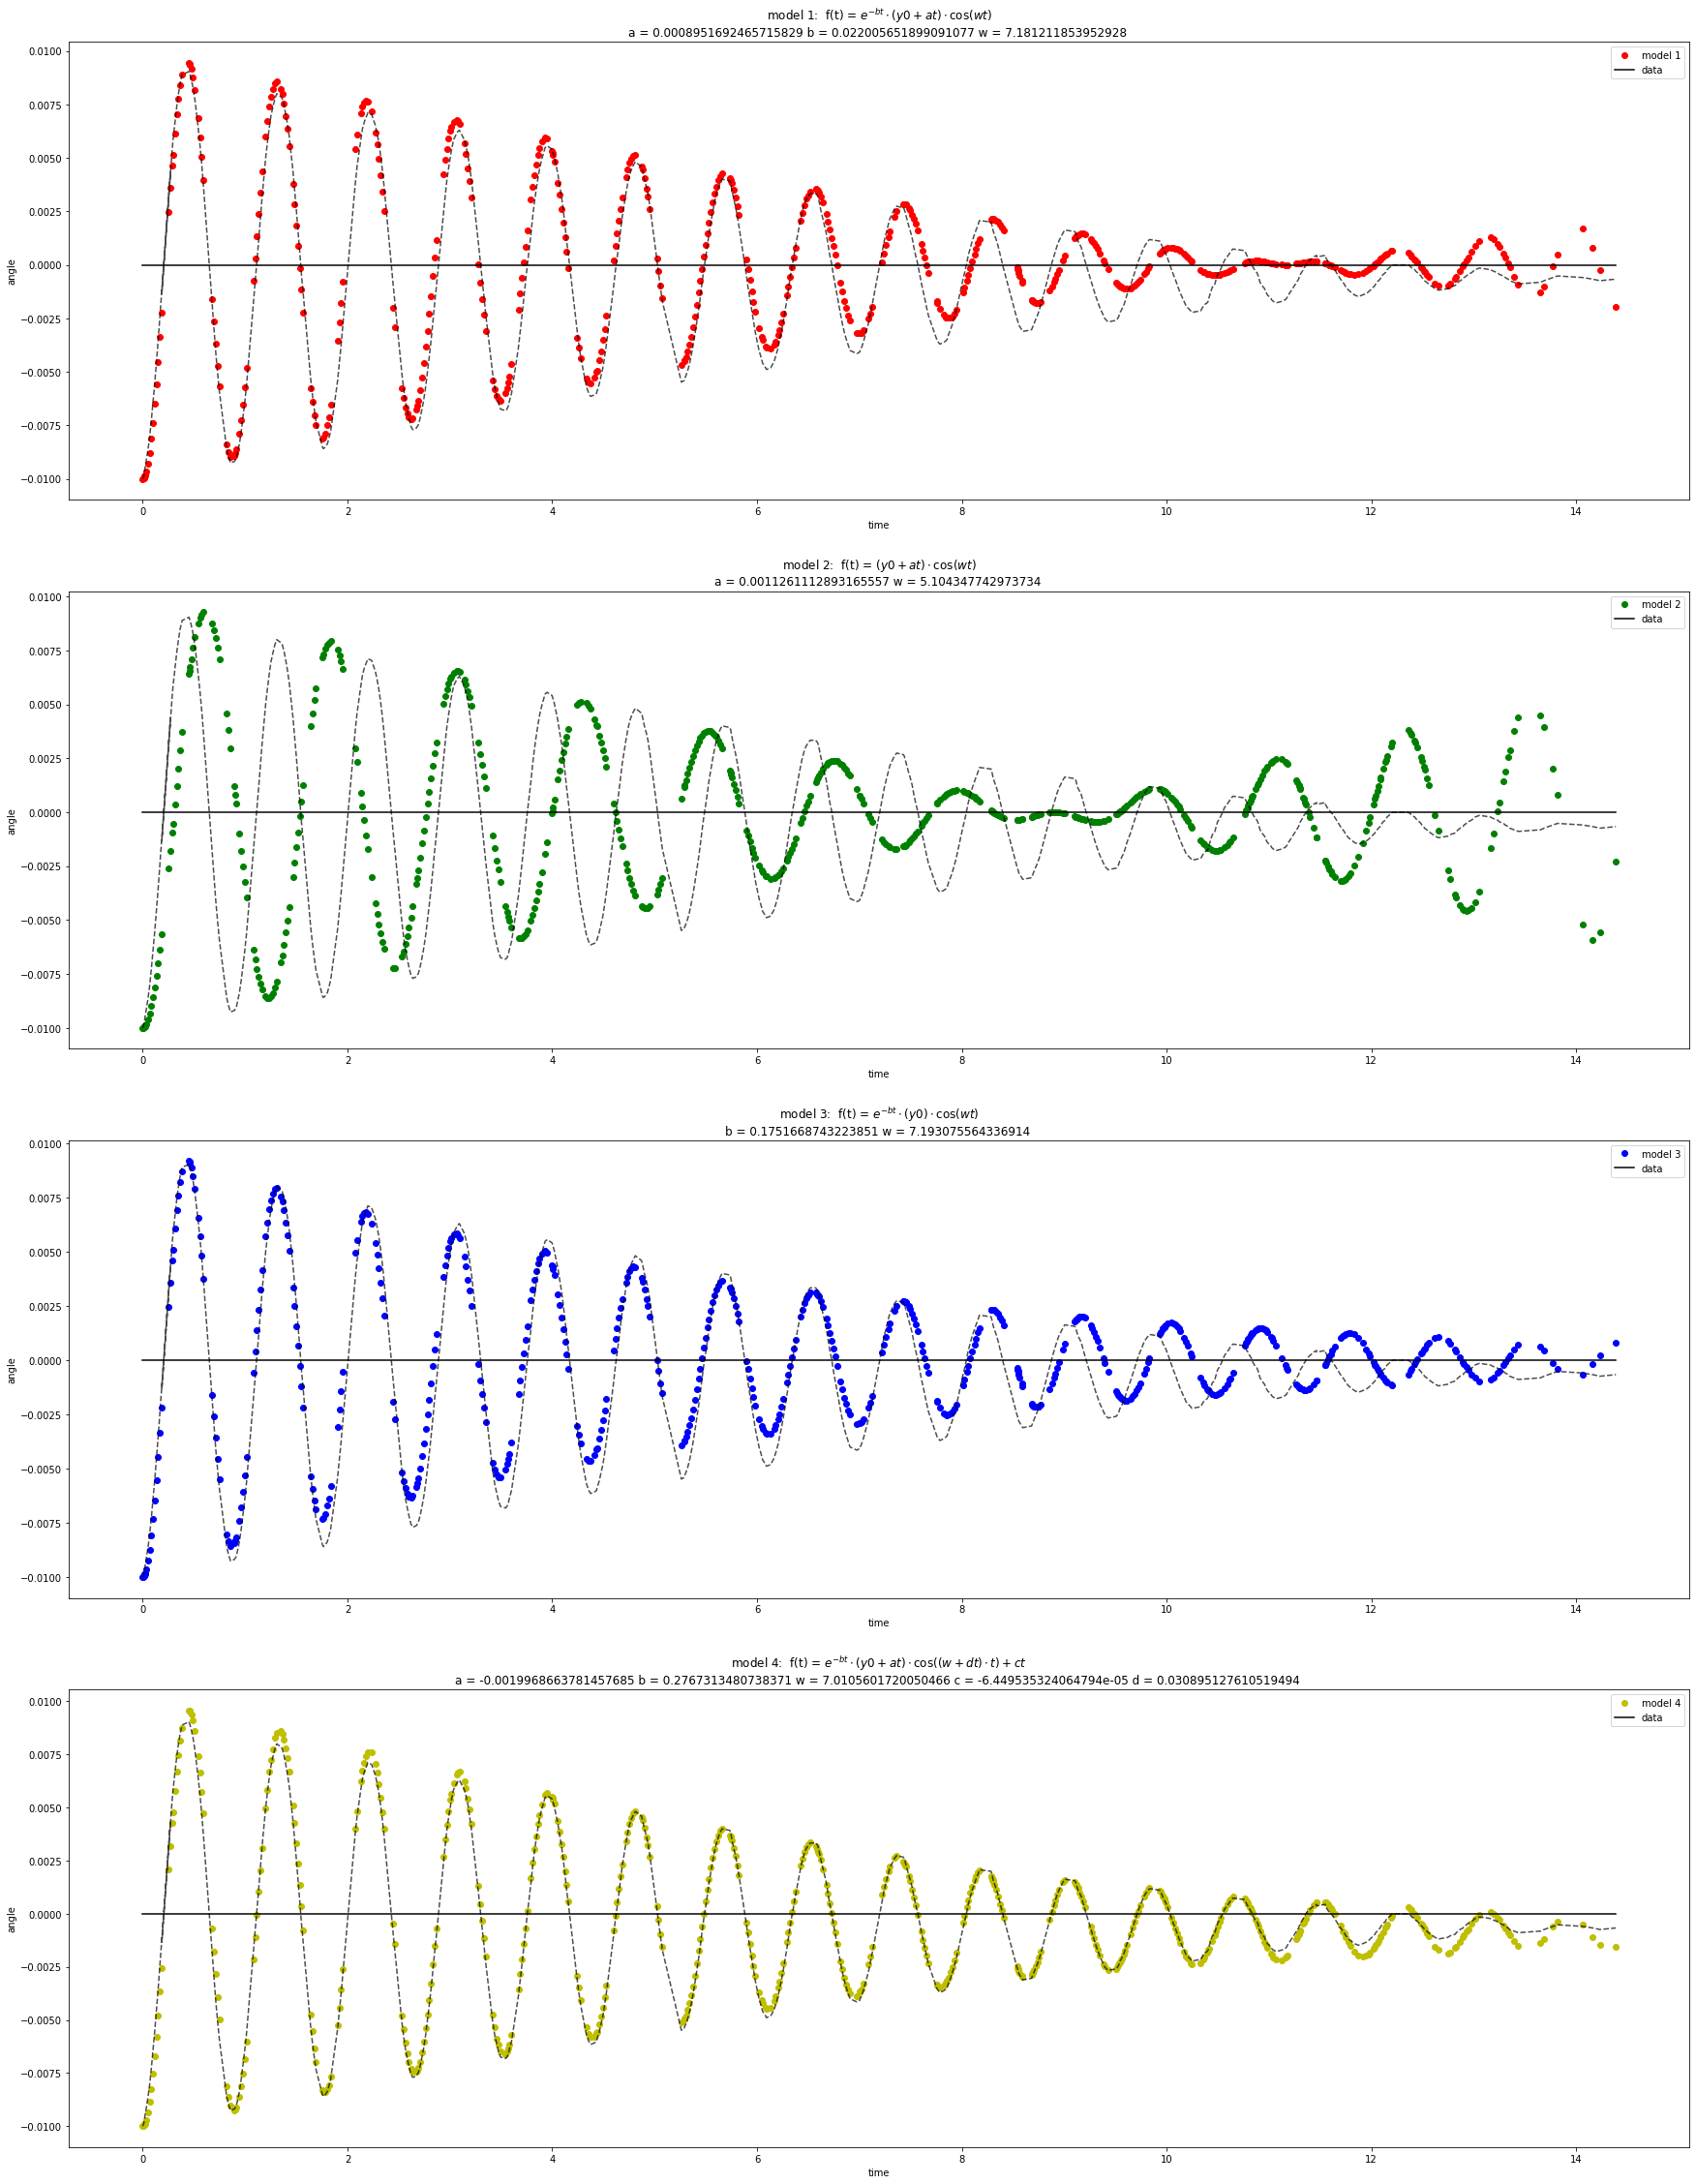

In [516]:
fig,axs = plt.subplots(figsize = (30,40),nrows = len(models))
for i in range(len(models)):
    axs[i].plot(t,models[i](np.array(t),*params[i]),['ro','go','bo','yo','ko'][i],label=f'model {i + 1}')
    axs[i].plot(t,0*t,'k',label = 'data')
    axs[i].plot(t,y,'k--',alpha = 0.7)
    axs[i].legend()
    named_params = [f'{name} = {param} ' for name,param in zip(param_names[i],params[i])]
    named_params = ''.join(named_params)
    axs[i].set_title(f'model {i + 1}:  f(t) = {formulas[i]}\n{named_params}')
    axs[i].set_ylabel('angle')
    axs[i].set_xlabel('time')
plt.show()

In [448]:
!pip install pytexit

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [640]:
from pytexit import py2tex
import inspect

class Model:
    def __init__(self,f):
        self.f = f
        self.f_name = f.__name__
        self.x_name = inspect.getfullargspec(f).args[0]
        self.param_names = inspect.getfullargspec(f).args[1:]
    
    def fit(self,data,tolerated_error = 0.000001,guess = None):
        if not guess:
            guess = np.random.rand(len(self.param_names))
        x,y = data
        self.params,self.covariance,*self.info = curve_fit(self.f,x,y,guess,xtol = tolerated_error,full_output = True)
        self.fitted = lambda x: self.f(x,*self.params)
        return self
    
    def get_formula(self):
        source_code = inspect.getsource(self.f)
        source_lines = source_code.split('\n')
        for line in source_lines:
            if line.strip().startswith("return"):
                return_statement = line.strip()
                break
        expression = return_statement[len("return "):]
        return py2tex(expression,print_latex = False,print_formula = False)
    
    def graph(self,data,usetex = False,figsize = None,**kwargs):
        x,y = data
        y_pred = self.fitted(x)
        fig,ax = plt.subplots(figsize = figsize)
        ax.plot(x,y_pred,label = 'predicted',**kwargs)
        ax.plot(x,y,'k--',alpha = 0.7,label = 'data')
        ax.legend()
        named_params = [f'{name} = {param} ' for name,param in zip(self.param_names,self.params)]
        named_params = ''.join(named_params)
        if usetex:
            self.formula = self.get_formula()
            ax.set_title(f'{self.f_name}({self.x_name}) = {self.formula[1:-1]}\n{named_params}')
        ax.set_ylabel(f'{self.f_name}({self.x_name})')
        ax.set_xlabel(f'{self.x_name}')
        return fig,ax
    

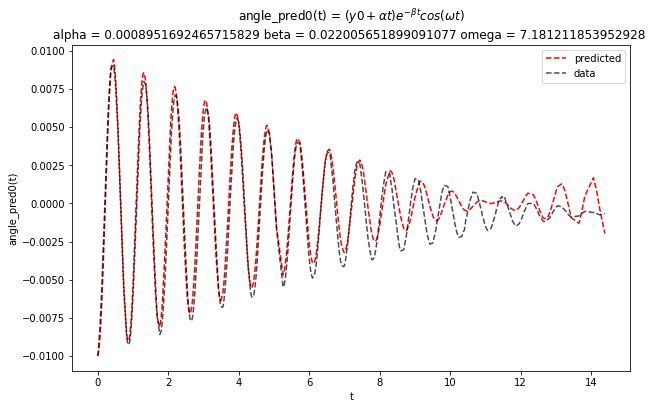

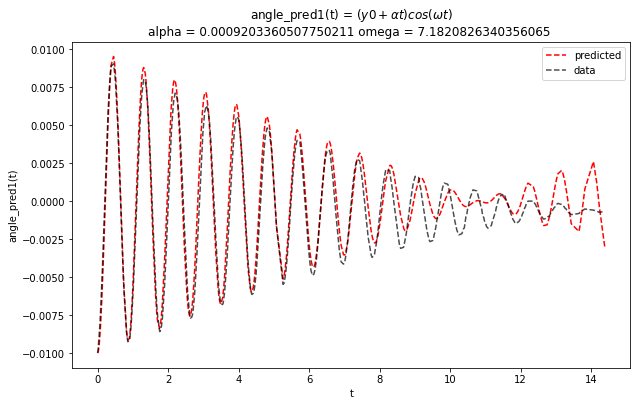

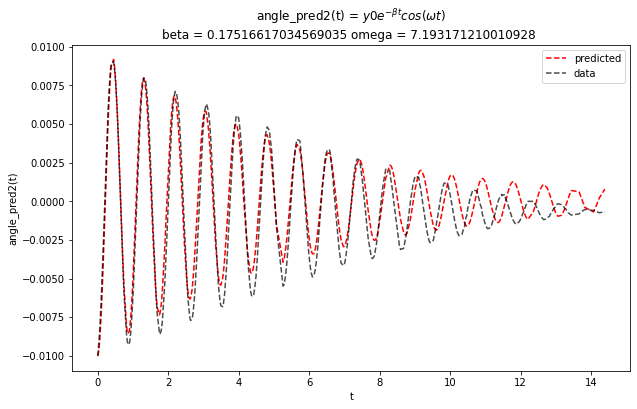

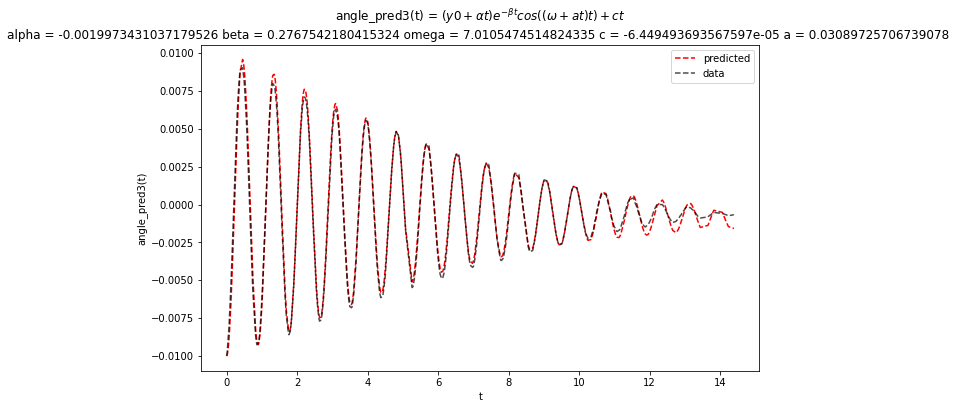

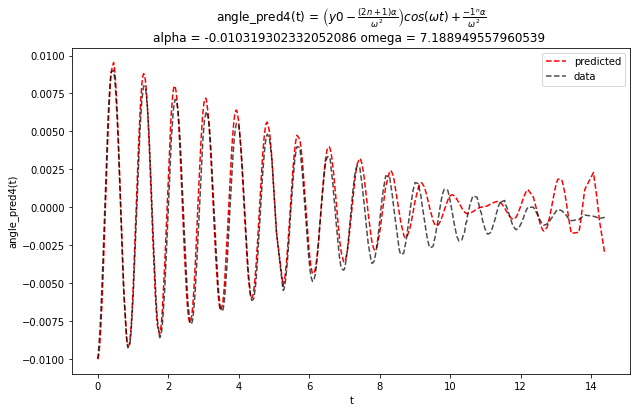

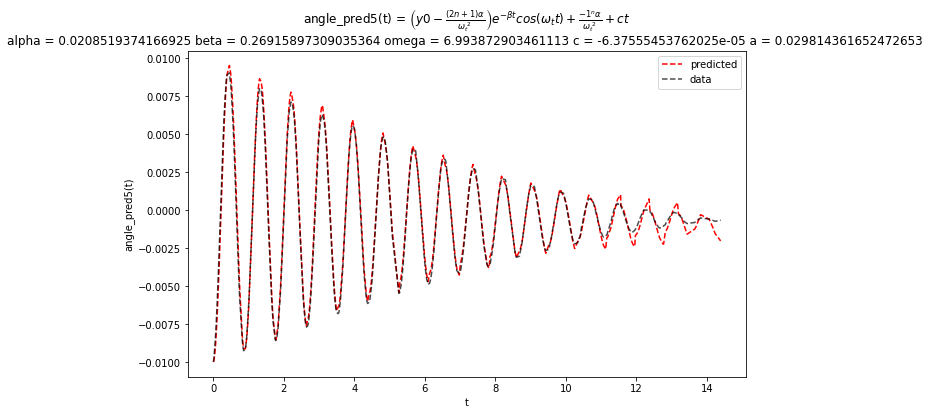

In [650]:
def angle_pred0(t, alpha, beta, omega):
    return (y0 + alpha * t) * np.exp(-beta * t) * np.cos(omega * t)

def angle_pred1(t, alpha, omega):
    return (y0 + alpha * t) * np.cos(omega * t)

def angle_pred2(t, beta, omega):
    return y0 * np.exp(-beta * t) * np.cos(omega * t)

def angle_pred3(t, alpha, beta, omega, c, a):
    return (y0 + alpha * t) * np.exp(-beta * t) * np.cos((omega + a * t) * t) + c * t

def angle_pred4(t, alpha, omega):
    n = np.floor(omega*t/np.pi)
    return ((y0 - (2*n + 1) * alpha/omega**2) * np.cos(omega * t) + (-1)**n*alpha/omega**2)

def angle_pred5(t, alpha, beta, omega, c, a):
    omega_t = omega + a * t
    n = np.floor(omega_t*t/np.pi)
    return ((y0 - (2*n + 1) * alpha/omega_t**2)* np.exp(-beta * t) * np.cos(omega_t * t) + (-1)**n*alpha/omega_t**2) + c * t

funcs = [angle_pred0,angle_pred1,angle_pred2,angle_pred3,angle_pred4,angle_pred5]
guesses = [[1,.1,5],[10,7],[1,5],[1,1,5,1,1],[10,7],[10,1,7,1,0]]
models = [Model(func) for func in funcs]

for model,guess in zip(models,guesses):
    model.fit((t,y),guess = guess)
    model.graph((t,y),usetex = True,figsize = (10,6),color = (1,0,0),linestyle = 'dashed')

In [ ]:
fig,ax = plt.subplots(figsize = (20,10))
alpha,omega = models[4].params
ax.plot(t,y,'k--',alpha = 0.7)
ax.plot(t,(y0 - (2*(np.floor(omega*t/np.pi)) + 1) * alpha/omega**2) + (-1)**(np.floor(omega*t/np.pi))*alpha/omega**2)
ax.plot(t,(y0 - (2*(np.floor(omega*t/np.pi)) + 1) * alpha/omega**2) * np.cos(omega * t) + (-1)**(np.floor(omega*t/np.pi))*alpha/omega**2)

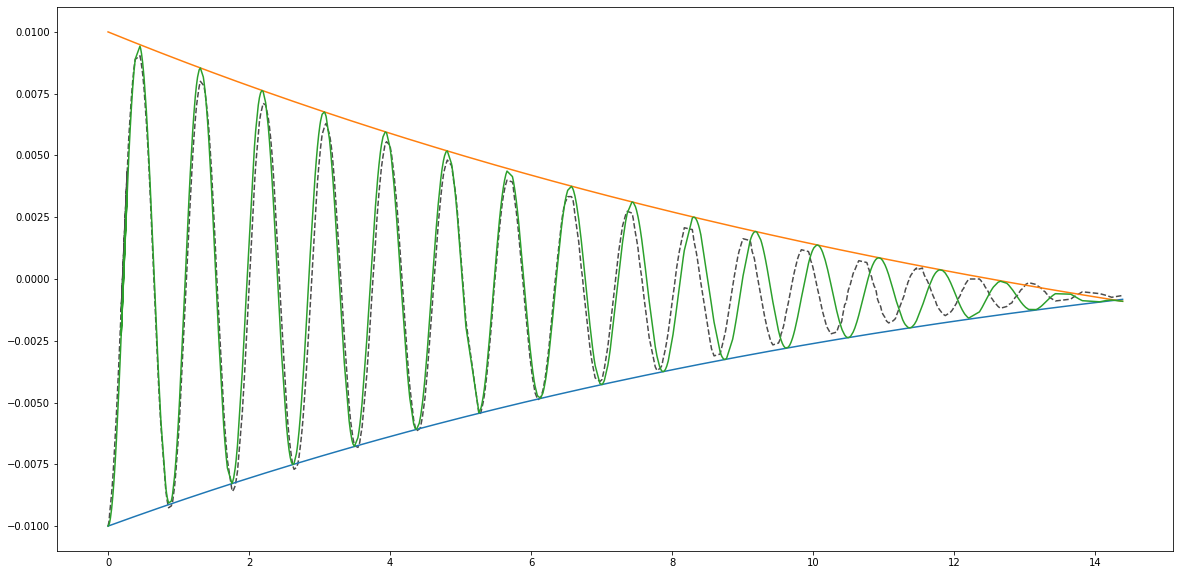

In [593]:
fig,ax = plt.subplots(figsize = (20,10))
alpha,omega = models[4].params
ax.plot(t,y,'k--',alpha = 0.7)
ax.plot(t,np.exp(-0.04*t)*(y0 + 0.0007 * t) - 6e-5*t)
ax.plot(t,np.exp(-0.04*t)*(-y0 - 0.0007 * t) - 6e-5*t)
ax.plot(t,np.exp(-0.04*t)*(y0 + 0.0007 * t)*np.cos(7.18*t) - 6e-5*t)

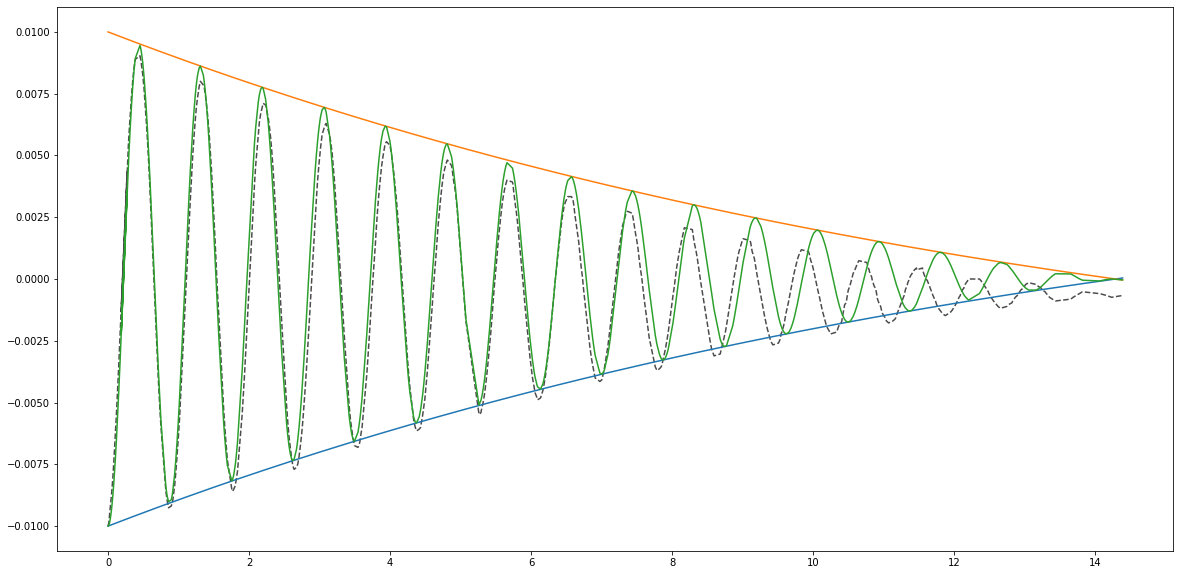

In [595]:
fig,ax = plt.subplots(figsize = (20,10))
alpha,omega = models[4].params
ax.plot(t,y,'k--',alpha = 0.7)
ax.plot(t,np.exp(-0.04*t)*(y0 + 0.0007 * t))
ax.plot(t,np.exp(-0.04*t)*(-y0 - 0.0007 * t))
ax.plot(t,np.exp(-0.04*t)*(y0 + 0.0007 * t)*np.cos(7.18*t))

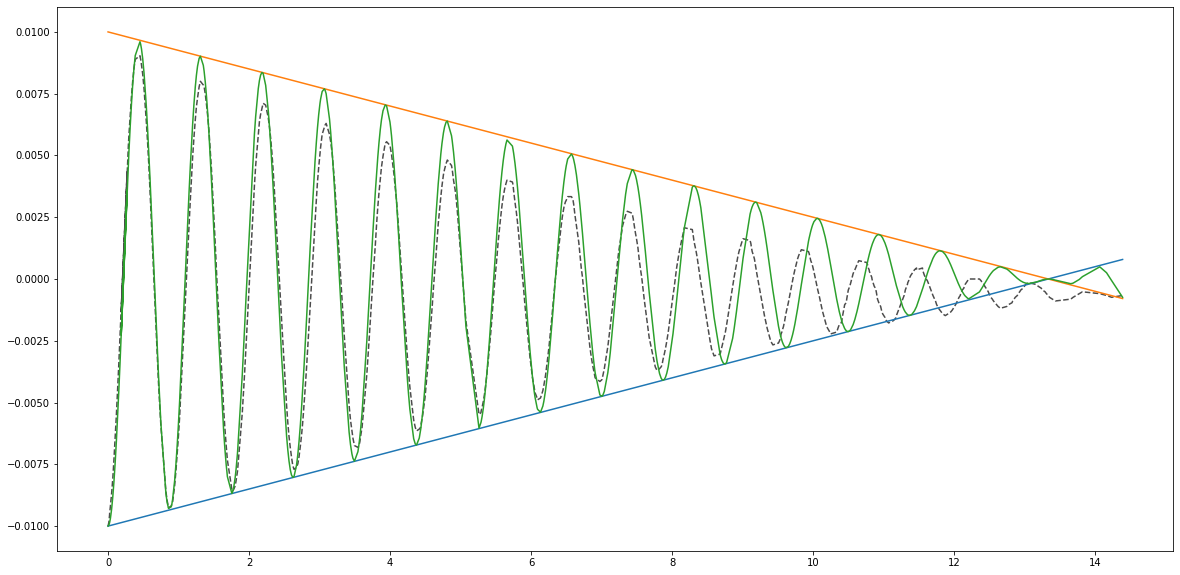

In [597]:
fig,ax = plt.subplots(figsize = (20,10))
alpha,omega = models[4].params
ax.plot(t,y,'k--',alpha = 0.7)
ax.plot(t,(y0 + 0.00075 * t))
ax.plot(t,(-y0 - 0.00075 * t))
ax.plot(t,(y0 + 0.00075 * t)*np.cos(7.18*t))

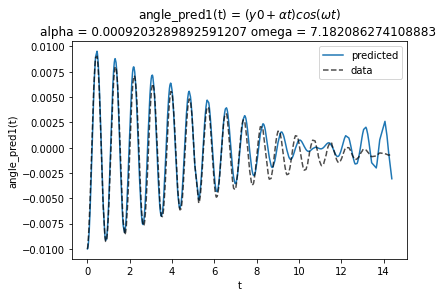

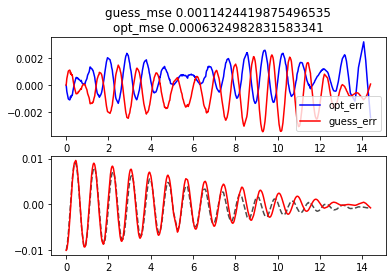

In [626]:
M = Model(angle_pred1)
M.fit((t,y),guess = (0.00075,7.18))
M.graph((t,y),usetex = True)
err = M.info[0]['fvec']
fig,(ax1,ax2) = plt.subplots(nrows = 2) 
ax1.plot(t,err,'b',label = 'opt_err')
ax1.plot(t,y - angle_pred1(t,0.00075,7.18),'r',label = 'guess_err')
ax1.set_title(f"guess_mse {sum((y - angle_pred1(t,0.00075,7.18))**2)}\nopt_mse {sum(err**2)}")
ax1.legend()
ax2.plot(t,y,'k--',alpha = 0.7)
ax2.plot(t,(y0 + 0.00075 * t)*np.cos(7.18*t),'r')